# **Student Placement Prediction Using Deep Learning**
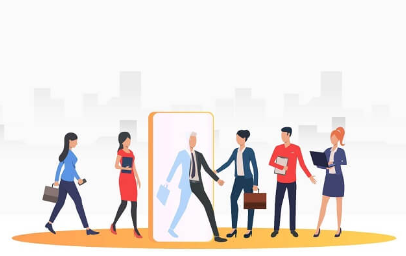

**Dataset :** https://archive.ics.uci.edu/dataset/320/student+performance

**By:** Praveen Choudhary

In [ ]:
# !pip install ucimlrepo
# !pip install summarytools
# !pip install keras-tuner

In [3]:
# Import library
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import count
from keras.layers import Dense, Dropout
import kerastuner as kt
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from summarytools import dfSummary as pc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [4]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

In [5]:
# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

In [6]:
# variable information
print(student_performance.variables)

          name     role         type      demographic  \
0       school  Feature  Categorical             None   
1          sex  Feature       Binary              Sex   
2          age  Feature      Integer              Age   
3      address  Feature  Categorical             None   
4      famsize  Feature  Categorical            Other   
5      Pstatus  Feature  Categorical            Other   
6         Medu  Feature      Integer  Education Level   
7         Fedu  Feature      Integer  Education Level   
8         Mjob  Feature  Categorical       Occupation   
9         Fjob  Feature  Categorical       Occupation   
10      reason  Feature  Categorical             None   
11    guardian  Feature  Categorical             None   
12  traveltime  Feature      Integer             None   
13   studytime  Feature      Integer             None   
14    failures  Feature      Integer             None   
15   schoolsup  Feature       Binary             None   
16      famsup  Feature       B

### **Data Frame Summary**

In [7]:
pc(X)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,school[object],1. GP2. MS,423 (65.2%)226 (34.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bwWnDQBRF0TdBmHgzQghUjIpIsSliuhFCs4iNN8rCkJC9/cb6uaeCb3wR2Oilfd8FOCRJZ0mn1ofgj9u+75fWRzxaN47jR855aH0IftVa15TSZ7TgupzzMM/zpe/7a+tjIG3b9l5KGZZlOUmKFZsk9X1/nabpq/Ux+HFufcAzvLU+AP8HscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNp10f2Gv9SG4i/xddLXWtZQyKOgLe0dUa10l3Vrf8WgMXl5TyMFLYsoHl8hPtpBPhyMLO+WLOoc7spBTvshzuCOLPOXj1/WL4U9d2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GATcsoX7fNEEXbKF3UOd2QMXmDzDQpbat+zDfyfAAAAAElFTkSuQmCC"">",0(0.0%)
2,sex[object],1. F2. M,383 (59.0%)266 (41.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABMElEQVR4nO3bwYnDQBBE0dIizPoygxAoGAWxwW4Qk40QmoNtfJk9bA7V4P4vgrb5CGxU0xhDgMMk6S7pFn1IEu8xxjP6iCjzuq4/pZQl+pAMeu/nNE2/WYObSynLvu/PWusr+phPdl3Xd2ttOY7jJilnbJJUa31t2/aIPiaBe/QBkb6iD0AexAYbYoMNscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22MzS/4t90Yd8Or5jae69n621Rclf7HPovZ+S3tF3RGHw4pV68DIx5YMLT7bkTxun9FO+7PM6p9RTPuZ1Xkz5+BVuw5+6sCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscEm9ZQv6+eOkn7Kl31e58TghcGLzR8KW2rflCE6AAAAAABJRU5ErkJggg=="">",0(0.0%)
3,age[int64],1. 172. 163. 184. 155. 196. 207. 218. 22,179 (27.6%)177 (27.3%)140 (21.6%)112 (17.3%)32 (4.9%)6 (0.9%)2 (0.3%)1 (0.2%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADPElEQVR4nO3dwW3bZgCG4Z+CkDYXCYIAj9Du4CEybIfQENnBMKxDkuaiHpJeZcGQX4rW80zwH16QJsFPnk6n04DCau4DcD/ERkZsZMRGRmxkxEZmGmN8HmN8mvsgF/p5Op2+z30I3ma93++/bDab3dwHucTxeHyepukfwS3TerPZ7B4fH79vt9sfcx/mnJeXlz8Ph8Pu6enp0xhDbAu0HmOM7Xb74+Hh4dvch7nA57kPwNt5QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzHuPX5ztzH+Q1Szgj562Px+Pz4XDYjQV8vnM8Hp/HGD/nPgdv47NwMpOfX6CypCubq9rCLWbwYuyyfIsYvBi7fAxLGrzc/NMy53mpS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmYRg5dbPx+XWczgxdhl+XwWTsbghYwHBDK3cht1i7wDN7Guspy6D7Ovqyyn7setrKtu+rUL1+EBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczs6yrLqftxE+sqy6n74LNwMtZVZOormyvYHUsHL4Yt9y0bvBi2UA9eDFvumJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZLLBi2EL6eDFsOW++SycjMELGQ8IZC65jbr1cRWvrqssoriWs+sqiyiu6ZJ1lUUUV+EBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczZdZVFFNf06rrKIopr8Vk4GesqMv9f2YarF+9tvd/vv4wxhlEL72212Wx2v9dVc/8bSD4479nIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcz693pqDAsq3pkNAhnrKjL+ZiOzmqbp72ma/MwC7241xvhrjPHH3Afh43MbJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjsxpjfB1j/Dv3Qfj4bBDIuI2SERsZgxcyBi9k3EbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjJuo2TERkZsZMRGRmxkxEbmP4H9LoZgTiZ+AAAAAElFTkSuQmCC"">",0(0.0%)
4,address[object],1. U2. R,452 (69.6%)197 (30.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bQarCMBSF4Rsp8pwklEIX00W4WBeR3ZTSDFSc5A3e/Fk6OOGS/1vBBX8FS0+otRqgEMzsZmbX1ofgsE+t9dX6iDOGaZruMcax9SE4ppSyhRAeHoMbYozjsiyvlNK79TH4377vPznncV3Xq5n5i83MLKX0nuf52foYHHJrfcBZl9YHoB/EBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIDGZ/L+W1PgTfef+chlLKlnMezfFLeT0ppWxm9ml9xxkMXvxxO3gJTPmg4v2Xze23vEeup3yeZ209cjvl8z5r65H3KR//oB3hoS5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskHE75fN4c+9cT/k8z9p6xOAFMr8KW2rfQnudGwAAAABJRU5ErkJggg=="">",0(0.0%)
5,famsize[object],1. GT32. LE3,457 (70.4%)192 (29.6%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOklEQVR4nO3bwYnDMBRF0a9gQrKRMAYX4yKm2BShboyxFpOQjWaRAmLP4omP7qng

In [8]:
pc(y)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,G1[int64],Mean (sd) : 11.4 (2.7)min < med < max:0.0 < 11.0 < 19.0IQR (CV) : 3.0 (4.2),17 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACdUlEQVR4nO3dP47aQBiG8W/CQgxIthASdFwgUgpKDpHD5ggpOAE3oENCCISzFsZ2qkiJsiTrf/G85vn1s0zxbGH4ZuyKojDAdx+63gDwHi9db6CPnHNjMxtVXH4riuK1yf30AaE2zDk3ns/nX8IwnFVZf7lcTs65r8T6O0Jt3igMw9lms3mNoigps/B8Pgfb7XZ2PB5HZkaovyDUlkRRlCwWi+8Vlo4b30wP8DAFCYQKCYQKCYQKCYQKCYQKCYQKCYQKCXzh75ksy4ZmFjrnqv6JXs4KEKpH4jgepmn6ebVaDQaDQamfX3/q66wAoXrkdru9BEEwWa/XyXK5PJVd3+dZAUL10HQ6rTonYNbTWQEepiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGB6akHalx0FuZ5Pmx6P+9Vc/Da26FrQn1DnYvO0jQNsiz7lCTJNzOrOqpXSd3Ba5+Hrgn1bZUvOtvv97Pdbje53++Dtjb3SJ3Ba9+Hrgn1L6pcdHY6nTofXK4xeN353h/hYQoSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSentmqsZxZ7OOjzzjT70Mtc5xZ7Nujzx3yeeXsfUyVKtx3Nms2yPPXfH9ZWx9DdXMqh13NvPjyPP/5vvL2HodKsrz9WVsPPVDAqFCAqFCAqFCAqFCAqFCAqFCgtffo6peT/6s2ryW3dtQVa8nf1ZtX8vubagmej35s2r7WvZ/huqcC8zsY5kPbkiY53mtf6Q4joPD4TApu+56vQZV13e11pfPbssPE51Qu93Wwa4AAAAASUVORK5CYII="">",0(0.0%)
2,G2[int64],Mean (sd) : 11.6 (2.9)min < med < max:0.0 < 11.0 < 19.0IQR (CV) : 3.0 (4.0),16 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClUlEQVR4nO3dvY7aQBRA4TvhRwYiW4AEHS8QKQUlfdo8bB4hBUVq3oAOgZARzloY41RE2WizhBl7mTt7vnpnmeJoxYy816aqKgF89+HRGwD+R/vRGwiRMaYnIl3L5aeqqp7q3E8ICLVmxpjeeDz+Gsfx0Gb94XDYG2O+EetzhFq/bhzHw8Vi8ZQkSX7PwjRNo+VyOdztdl0RIdQ/EGpDkiTJJ5PJT4ulvdo3EwAOU1CBUKECoUIFQoUKHKY8U5ZlR0RiY4ztrwjyHpZQPZJlWacois+z2azVarXuutq6CvUellA9cjqd2lEU9efzeT6dTvf3rg/5HpZQPTQYDGzvYEUCvYflMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgWeR/0Hh7E88eVy6dS9n/eOUF/gMpanKIqoLMtPeZ5/FxHbh5/xF0J9mfVYnvV6PVytVv3z+dxqanPvEaG+wmYsz36/D/JfQR6NwxRUIFSoQKhQge+ogXGctOLtlBVCDYjrpBWfp6wQakBcJq34PmWFUAPkMGnF26s1DlNQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChV4egq/+fx6S0KFiPj/ektChYj4/3pLQsUzvr7eksMUVCBUqECoUIFQoUKwhymH+aYizDj1TpChusw3FWHGqY+CDFUc5puKMOPUR6GGKiJ2801FmHFqq8m5V0GHirfT9Nyrm6E6Hkq8nQ6HejU99+rVUF0PJT5Ph0Mzmpp7desvqvWhpI6HFHiFDq4a/Y5almVb7L9cR6PR6EuSJB/vXXi9Xtputz9sPvh4PEYiIlmWRZvNpq9hrebPTtM0uvUzvwCDXGPRcMzh1wAAAABJRU5ErkJggg=="">",0(0.0%)
3,G3[int64],Mean (sd) : 11.9 (3.2)min < med < max:0.0 < 12.0 < 19.0IQR (CV) : 4.0 (3.7),17 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiUlEQVR4nO3dT4riQBiG8a9GbaJCRATdeYGBWbj0EHPYOcIsPIE3cCeIRMx0UGNmNTANPf6pJFhvzfPbxxT0E+ngl4qrqsqA0H159QKAR3RfvYAYOef6Zvbmefipqqr3JtcTA0JtmHOuP5lMvqdpOvY5/nA47J1zP4j1I0Jt3luapuPlcvk+Go2KZw7MsixZrVbj3W73ZmaE+hdCbcloNCqm0+kvj0P7jS8mAtxMQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgJDKYEpy7JnZqlzzvcjopxnJdSA5HneO5/P3+bzeafT6Tw1IvhHrPOshBqQ0+nUTZJksFgsitlstn/2+JjnWQk1QMPh0HeW1SzSeVZupiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBn1AjU3P6KtjJK0KNSN3pq5Anrwg1InWmr0KfvCLUCNWYvgp28oqbKUggVEggVEggVEggVEggVEggVEggVEggVEggVEjgJ9R/qPE+0/R6vfaaXs//jlA/Ued9pufzOSnL8mtRFD/NzHe3k5cIeYM2Qv2c9/tMN5vNeL1eDy6XS6etxbUh9A3aCPUGn/eZ7vf7YCeQbgl9gzZCxQehbtDGXT8kECokECokECokECokECokECokECokECokECokECokECokMJSCxrS55eXdUGtMut89OeLR9paXN0OtM+n+yMnbVPMC43GSJ7W95eW9b1TvSfdX7rdZ9wJTfpzk1dra8vKh/1F9Jt0fOXmLvC8wM93HSWIW9c2U7wWm+jhJzB4KNcuy5NkPzrIsKcuya/WeavSVXq/Xrs+6zcyOx2NiZpbnebLdbgcKxyqf+5G/029OV2RGPzoO9QAAAABJRU5ErkJggg=="">",0(0.0%)


In [9]:
y.head(15)

,G1,G2,G3
0,0,11,11
1,9,11,11
2,12,13,12
3,14,14,14
4,11,13,13
5,12,12,13
6,13,12,13
7,10,13,13
8,15,16,17
9,12,12,13


In [10]:
# Convert datatype into integer
y['G1']=y['G1'].astype(int)
y['G2']=y['G2'].astype(int)
y['G3']=y['G3'].astype(int)

In [11]:
# Make A New Column Of Place Or not place
y['Placed']=y['G3'].apply(lambda x: 1 if x>=11.9 else 0)

In [12]:
y.head(5)

,G1,G2,G3,Placed
0,0,11,11,0
1,9,11,11,0
2,12,13,12,1
3,14,14,14,1
4,11,13,13,1


In [13]:
# Inster y all grade data into x
X['G1'] = y['G1']
X['G2'] = y['G2']
X['G3'] = y['G3']

In [14]:
# Create the target variable by dropping unnecessary columns
y=y.drop(columns=['G1','G2','G3'])

In [15]:
y.head(5)

,Placed
0,0
1,0
2,1
3,1
4,1


In [16]:
y.value_counts()

,count
Placed,
1,348
0,301



> **Placed:** 348

> **Not Placed:** 301

In [17]:
X.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### **Convert Text To numeric**


In [18]:
# Convert Text To numeric
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Label Encoding for Gender
label_encoder = LabelEncoder()
X['sex'] = label_encoder.fit_transform(X['sex'])
X['school'] = label_encoder.fit_transform(X['school'])
X['address'] = label_encoder.fit_transform(X['address'])
X['Mjob'] = label_encoder.fit_transform(X['Mjob'])
X['Fjob'] = label_encoder.fit_transform(X['Fjob'])
X['reason'] = label_encoder.fit_transform(X['reason'])

# One-Hot Encoding for Ethnicity and Age
# X = pd.get_dummies(X, columns=['Ethnicity'], prefix='Ethnicity')
X = pd.get_dummies(X, columns=['Mjob'], prefix='Mjob')
X = pd.get_dummies(X, columns=['Fjob'], prefix='Fjob')
X = pd.get_dummies(X, columns=['guardian'], prefix='guardian')
# Convert object type columns to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)


In [19]:
X.head(5)

,school,sex,age,address,Medu,Fedu,reason,traveltime,studytime,failures,...,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0,0,18,1,4,4,0,2,2,0,...,False,False,True,False,False,False,True,True,False,False
1,0,0,17,1,1,1,0,1,2,0,...,False,True,False,True,False,False,False,True,True,False
2,0,0,15,1,1,1,2,1,2,0,...,True,True,True,False,False,False,True,True,True,False
3,0,0,15,1,4,2,1,1,3,0,...,False,True,False,True,False,True,True,True,True,True
4,0,0,16,1,3,3,1,1,2,0,...,False,True,False,True,False,False,True,True,False,False


In [20]:
X.describe()

,school,sex,age,address,Medu,Fedu,reason,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,0.348228,0.409861,16.744222,0.696456,2.514638,2.306626,1.112481,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,0.476776,0.492187,1.218138,0.460143,1.134552,1.099931,1.192045,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,0.000000,0.000000,17.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,1.000000,1.000000,18.000000,1.000000,4.000000,3.000000,2.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,1.000000,1.000000,22.000000,1.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [21]:
print(X.dtypes)


school             int64
sex                int64
age                int64
address            int64
Medu               int64
Fedu               int64
reason             int64
traveltime         int64
studytime          int64
failures           int64
famrel             int64
freetime           int64
goout              int64
Dalc               int64
Walc               int64
health             int64
absences           int64
G1                 int64
G2                 int64
G3                 int64
Mjob_0              bool
Mjob_1              bool
Mjob_2              bool
Mjob_3              bool
Mjob_4              bool
Fjob_0              bool
Fjob_1              bool
Fjob_2              bool
Fjob_3              bool
Fjob_4              bool
guardian_father     bool
guardian_mother     bool
guardian_other      bool
famsize_LE3         bool
Pstatus_T           bool
schoolsup_yes       bool
famsup_yes          bool
paid_yes            bool
activities_yes      bool
nursery_yes         bool


### **Scaling**

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X is your encoded data
scaler = MinMaxScaler()

# Fit and transform the data to scale it
X = scaler.fit_transform(X)

In [23]:
print(X[1])

[0.         0.         0.28571429 1.         0.25       0.25
 0.         0.         0.33333333 0.         1.         0.5
 0.5        0.         0.         0.5        0.0625     0.47368421
 0.57894737 0.57894737 1.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         1.         0.
 1.         0.         0.         0.         1.         1.
 0.        ]


In [24]:
X.shape

(649, 43)

### **Train-Test Split**

In [25]:
# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Bulid Model**

In [64]:
def build_model(hp):

  model = Sequential()

  counter = 0

  for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
    if counter == 0:
      model.add(
          Dense(
              hp.Int('units' + str(i), min_value=8, max_value=512, step=16),
              activation=hp.Choice('activation' + str(i), values=['relu', 'tanh', 'sigmoid']),
              input_dim=43))
      model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
    else:
      model.add(
          Dense(
              hp.Int('units' + str(i), min_value=8, max_value=512, step=16),
              activation=hp.Choice('activation' + str(i), values=['relu', 'tanh', 'sigmoid']))
          )
      model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    counter += 1
  model.add(Dense(1, activation='sigmoid'))
  model.compile(
        optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam','SGD']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
  return model

In [67]:
tunner = kt.RandomSearch(build_model,objective='val_accuracy',max_trials=10,
                         directory = 'mydir',
                         project_name = 'All_in_one3')

In [68]:
# searching the best model.
tunner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.8461538553237915

Best val_accuracy So Far: 0.8769230842590332
Total elapsed time: 00h 02m 47s


In [69]:
tunner.get_best_hyperparameters()[0].values

{'num_layers': 5,
 'units0': 440,
 'activation0': 'tanh',
 'dropout0': 0.3,
 'optimizer': 'adam',
 'units1': 40,
 'activation1': 'tanh',
 'dropout1': 0.3,
 'units2': 488,
 'activation2': 'tanh',
 'dropout2': 0.2,
 'units3': 408,
 'activation3': 'tanh',
 'dropout3': 0.2,
 'units4': 72,
 'activation4': 'sigmoid',
 'dropout4': 0.3,
 'units5': 104,
 'activation5': 'relu',
 'dropout5': 0.3,
 'units6': 376,
 'activation6': 'relu',
 'dropout6': 0.2,
 'units7': 184,
 'activation7': 'sigmoid',
 'dropout7': 0.2,
 'units8': 328,
 'activation8': 'relu',
 'dropout8': 0.2,
 'units9': 104,
 'activation9': 'relu',
 'dropout9': 0.4}

In [78]:
# Take best model
model = tunner.get_best_models(num_models=1)[0]

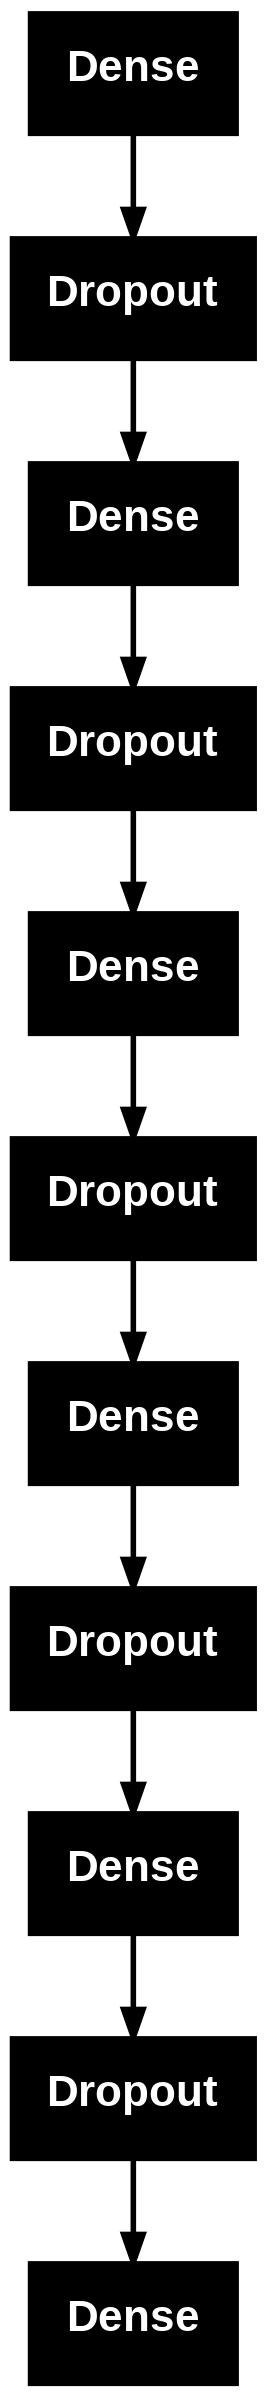

In [79]:
from keras.utils import plot_model
plot_model(model,show_shapes=False)

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # No. of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce learning rate by a factor of 0.1
    patience=10,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=0.0000001  # The minimum learning rate to reduce to
)


In [81]:
# Traing the model
history = model.fit(X_train,y_train,batch_size=128,epochs=500,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping, reduce_lr])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 865ms/step - accuracy: 0.8617 - loss: 0.3018 - val_accuracy: 0.8538 - val_loss: 0.3096 - learning_rate: 0.0010
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8752 - loss: 0.2838 - val_accuracy: 0.8615 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8726 - loss: 0.2787 - val_accuracy: 0.8692 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8741 - loss: 0.3019 - val_accuracy: 0.8462 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8649 - loss: 0.3057 - val_accuracy: 0.8692 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8806 - loss: 0.2880 - val_accuracy: 0.8846 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8627 - loss: 0.2834 - val_accuracy: 0.

In [82]:
model.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9317 - loss: 0.1824  


[0.17106713354587555, 0.9384615421295166]

In [83]:
predictions1=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


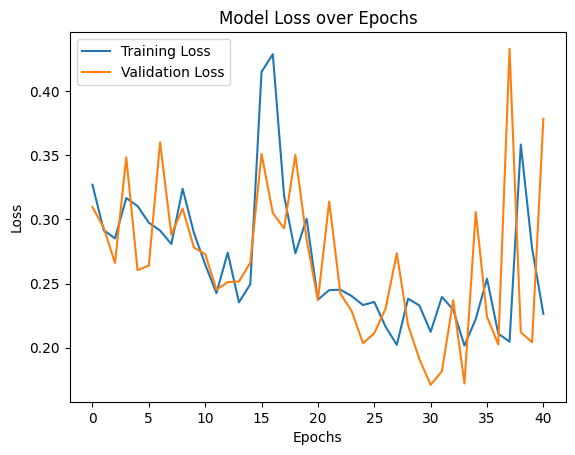

In [84]:
import matplotlib.pyplot as plt

# Plotting the loss and val_loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and legend
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [85]:
#Predicted On The Test Set
y_pred= model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [86]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix,classification_report

# Convert predictions to binary values (adjust threshold as needed)
threshold = 0.5  # Example threshold
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
print(cm)

[[53  4]
 [ 4 69]]


In [90]:
# Classification Report
print("\nClassification Report:")
classification_metrics = classification_report(y_test, y_pred_binary, target_names=['Not Place 0', 'Place 1'])
print(classification_metrics)


Classification Report:
              precision    recall  f1-score   support

 Not Place 0       0.93      0.93      0.93        57
     Place 1       0.95      0.95      0.95        73

    accuracy                           0.94       130
   macro avg       0.94      0.94      0.94       130
weighted avg       0.94      0.94      0.94       130



### **Confusion Matric**

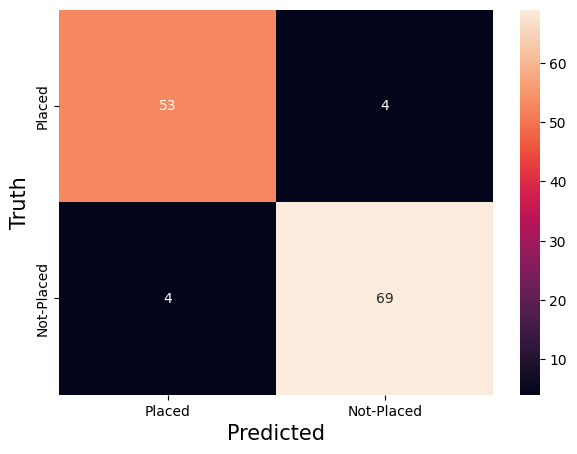

In [91]:
# confusion metric visual
import seaborn as sn
plt.figure(figsize=(7,5))
cm_df = pd.DataFrame(cm,
                     index = ['Placed','Not-Placed'],
                     columns = ['Placed','Not-Placed'])
sn.heatmap(cm_df,annot=True)

plt.xlabel('Predicted',color='black',size=15)
plt.ylabel('Truth',color='black',size=15)
plt.show()

### **Conclusion**

The deep learning model performed well in predicting student placements, achieving an overall accuracy of 94%. The classification report indicates strong performance across both classes—students who were placed and those who were not. The model demonstrated a precision of 0.95 and recall of 0.95 for placed students, indicating that it correctly identified most of the students who secured placements. Similarly, for students who were not placed, the precision and recall were both 0.93, highlighting the model's balanced performance.

With a high F1-score for both classes (0.93 for "Not Placed" and 0.95 for "Placed"), the model effectively balances precision and recall, making it a reliable tool for predicting student placements. This result suggests that the model can be used confidently to assist in identifying placement trends and outcomes.